<a href="https://colab.research.google.com/github/timnll/ProjetBigData/blob/master/NYC_Taxi_Records.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA**

### *Import librairies*

In [0]:
from __future__ import print_function

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import yaml
import time, datetime
import os.path, sys
from matplotlib.pyplot import figure

!pip install pyshp
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

# MatPlotLib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### *Functions*

In [0]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])


def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max



def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])



def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values())) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id),fontsize=10, color="white", bbox=dict(facecolor='black', alpha=0.5), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

### Import data

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1bJbQgQae2zuWdeN4J-v67YNmFRdaxCph' #shareable link

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('yellow_tripdata_2019-01.csv')  
datas_2019_01 = pd.read_csv('yellow_tripdata_2019-01.csv')
# Dataset is now stored in a Pandas Dataframe
print (datas_2019_01)

1bJbQgQae2zuWdeN4J-v67YNmFRdaxCph
         VendorID tpep_pickup_datetime  ... total_amount  congestion_surcharge
0               1  2019-01-01 00:46:40  ...         9.95                   NaN
1               1  2019-01-01 00:59:47  ...        16.30                   NaN
2               2  2018-12-21 13:48:30  ...         5.80                   NaN
3               2  2018-11-28 15:52:25  ...         7.55                   NaN
4               2  2018-11-28 15:56:57  ...        55.55                   NaN
5               2  2018-11-28 16:25:49  ...        13.31                   NaN
6               2  2018-11-28 16:29:37  ...        55.55                   NaN
7               1  2019-01-01 00:21:28  ...         9.05                   NaN
8               1  2019-01-01 00:32:01  ...        18.50                   NaN
9               1  2019-01-01 00:57:32  ...        13.00                   NaN
10              1  2019-01-01 00:24:04  ...        19.55                   NaN
11              1 

### *Import NYC shape*

taxi_zones  taxi_zones.dbf  taxi_zones.shp  yellow_tripdata_2019-01.csv
1bJbQgQae2zuWdeN4J-v67YNmFRdaxCph


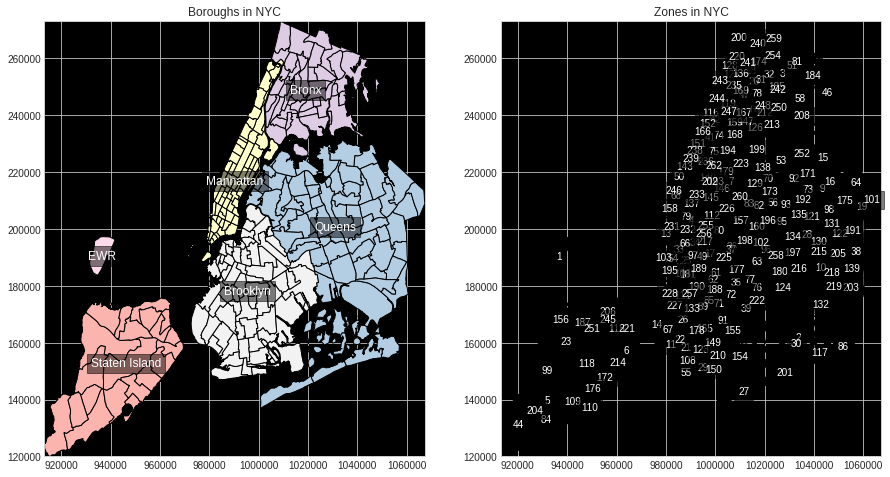

In [0]:
!ls "/content/drive/My Drive/Projet_Big_Data"

#link2 = 'https://drive.google.com/open?id=1bxIZN6o8vt9vIRjMCOe5sVtID0PVmWg0' #shareable link
#link3 = 'https://drive.google.com/open?id=1eyX2FrjGILBmYCn-E3qOQ890YvTvWyjB'
#link4 = 'https://drive.google.com/open?id=1Szvn1OUXMY7OsBityUD-OoAnV8hjY84t'

#fluff2, id2 = link3.split('=')
#fluff3, id3 = link4.split('=')
print (id) # Verify that you have everything after '='

#downloaded2 = drive.CreateFile({'id':id}) 
#downloaded2.GetContentFile('taxi_zones')

sf = shapefile.Reader("/content/drive/My Drive/Projet_Big_Data/taxi_zones")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf)


### *Clean data*

In [0]:
runs_2019_01 = datas_2019_01.copy()
runs_2019_01.columns = ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge']

useless_columns = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'congestion_surcharge']
runs_2019_01 = runs_2019_01.drop(columns=useless_columns)
runs_2019_01['tpep_pickup_datetime'] = pd.to_datetime(runs_2019_01['tpep_pickup_datetime'])
runs_2019_01['tpep_dropoff_datetime'] = pd.to_datetime(runs_2019_01['tpep_dropoff_datetime'])
runs_2019_01
#print(runs_2019_01)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.50,151,239,1,7.0,0.5,0.5,1.65,0.00,0.3,9.95
1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.60,239,246,1,14.0,0.5,0.5,1.00,0.00,0.3,16.30
2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.00,236,236,1,4.5,0.5,0.5,0.00,0.00,0.3,5.80
3,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.00,193,193,2,3.5,0.5,0.5,0.00,0.00,0.3,7.55
4,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.00,193,193,2,52.0,0.0,0.5,0.00,0.00,0.3,55.55
5,2018-11-28 16:25:49,2018-11-28 16:28:26,5,0.00,193,193,2,3.5,0.5,0.5,0.00,5.76,0.3,13.31
6,2018-11-28 16:29:37,2018-11-28 16:33:43,5,0.00,193,193,2,52.0,0.0,0.5,0.00,0.00,0.3,55.55
7,2019-01-01 00:21:28,2019-01-01 00:28:37,1,1.30,163,229,1,6.5,0.5,0.5,1.25,0.00,0.3,9.05
8,2019-01-01 00:32:01,2019-01-01 00:45:39,1,3.70,229,7,1,13.5,0.5,0.5,3.70,0.00,0.3,18.50
9,2019-01-01 00:57:32,2019-01-01 01:09:32,2,2.10,141,234,1,10.0,0.5,0.5,1.70,0.00,0.3,13.00


# **TRAITEMENT**

### *Hour frequency*

Text(0.5,0,'hours')

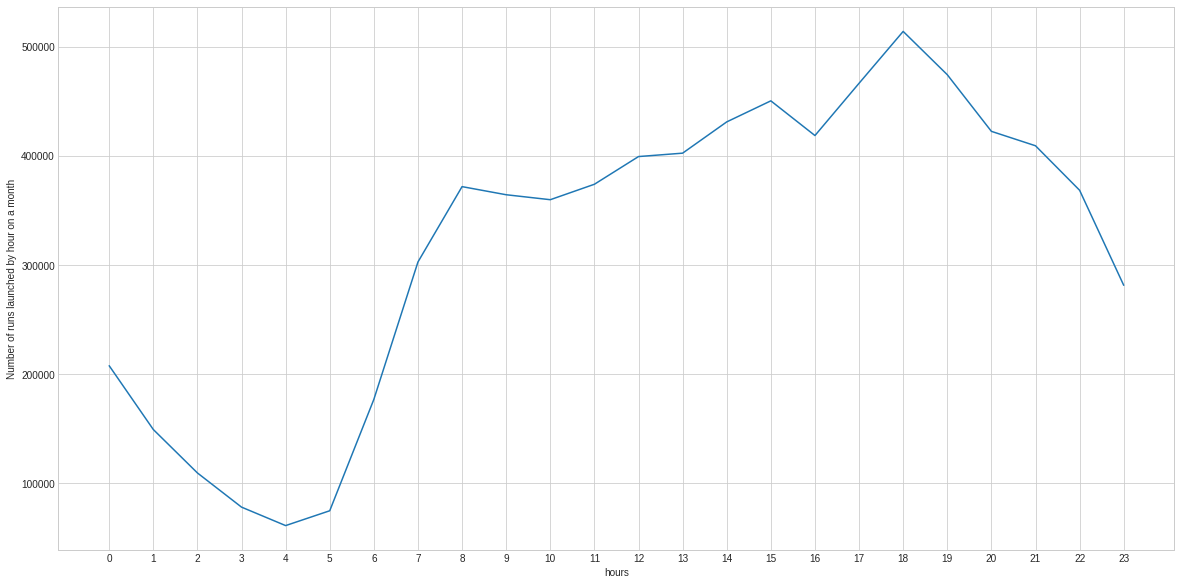

In [0]:
frequency_by_hour = []
runs = []
hour = pd.date_range("00:00", "23:00",freq="1H").time

for hour in hour:
  if hour == datetime.time(23, 0):
      runs = runs_2019_01[runs_2019_01['tpep_pickup_datetime'].dt.time.between(hour, (datetime.datetime.combine(datetime.date(1,1,1),hour) + datetime.timedelta(seconds=3599)).time())]
      frequency_by_hour.append(len(runs))
  else:
    runs = runs_2019_01[runs_2019_01['tpep_pickup_datetime'].dt.time.between(hour, (datetime.datetime.combine(datetime.date(1,1,1),hour) + datetime.timedelta(hours=1)).time())]
    frequency_by_hour.append(len(runs))

#print(frequency_by_hour)
hours=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] #x label

plt.figure(figsize=(20,10))
ax = plt.axes()
ax.plot(hours,frequency_by_hour)
plt.xticks(np.arange(min(hours), max(hours)+1, 1.0))
plt.ylabel("Number of runs launched by hour on a month")
plt.xlabel("hours")



### *Average run time*

[4164535, 2701780, 883767, 305803, 116708, 47232, 19260, 7288, 2533, 935, 389, 180]


Text(0.5,0,'time interval in minutes')

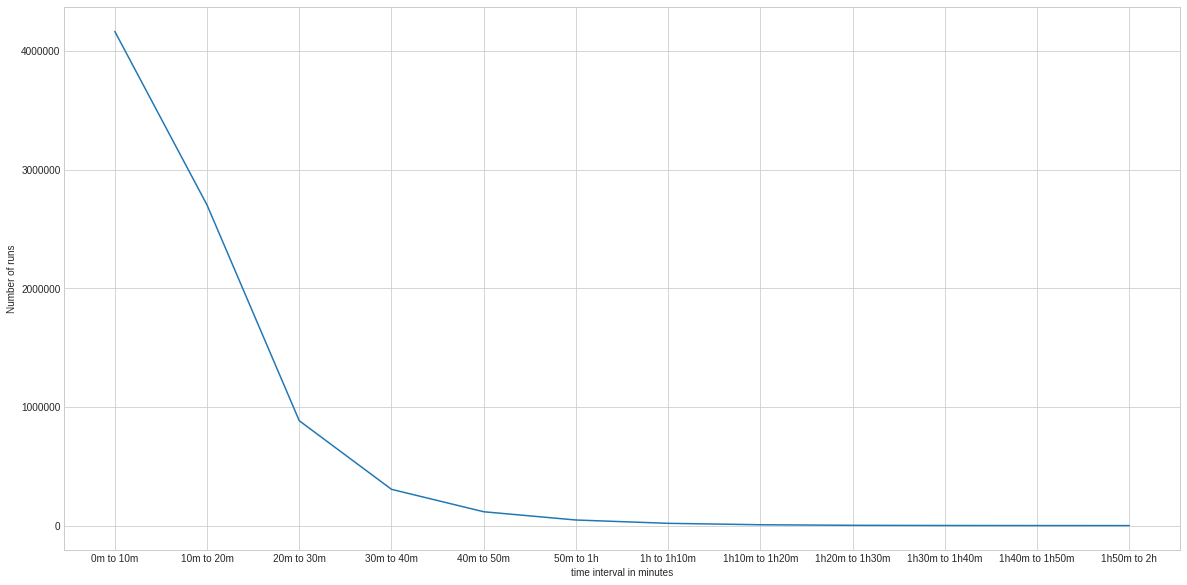

In [0]:
Average_time_run = []
runs = []
time_interval = 10
time_interval_label = [0, 1*time_interval, 2*time_interval,3*time_interval,
                       4*time_interval, 5*time_interval,6*time_interval,
                       7*time_interval, 8*time_interval, 9*time_interval,
                       10*time_interval, 11*time_interval]

for interval in time_interval_label:
  runs = runs_2019_01[(runs_2019_01['tpep_dropoff_datetime'] - runs_2019_01['tpep_pickup_datetime']).astype('timedelta64[m]').between(interval, interval + time_interval)]
  Average_time_run.append(len(runs))

print(Average_time_run)

plt.figure(figsize=(20,10))
ax = plt.axes()
x_label = ["0m to 10m", "10m to 20m", "20m to 30m", "30m to 40m", "40m to 50m", "50m to 1h", "1h to 1h10m", "1h10m to 1h20m", "1h20m to 1h30m", "1h30m to 1h40m", "1h40m to 1h50m", "1h50m to 2h"]
ax.plot(x_label,Average_time_run)
plt.ylabel("Number of runs")
plt.xlabel("time interval in minutes")

### *Most frequent pickup location*

In [0]:
#affiche les zones de pick up de la plus fréquente à la moins fréquente

df_pu = runs_2019_01['PULocationID'].to_frame()
runs_pu = []
nb_pu = []

template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])

for LocationID in template['LocationID']:
  runs_pu = df_pu.loc[df_pu['PULocationID'] == LocationID]
  nb_pu.append([df_loc['zone'].iloc[LocationID], df_loc['borough'].iloc[LocationID], len(runs_pu)])

nb_pu = pd.DataFrame(nb_pu, columns=["zone", "borough", "number_of_pick_ups"]) 
nb_pu.sort_values(by=['number_of_pick_ups'], ascending=False)

,zone,borough,number_of_pick_ups
236,Times Sq/Theatre District,Manhattan,332473
235,Sutton Place/Turtle Bay North,Manhattan,323008
160,Marine Park/Floyd Bennett Field,Brooklyn,312392
161,Marine Park/Mill Basin,Brooklyn,277166
229,Steinway,Queens,263646
185,Old Astoria,Queens,260712
47,Clinton Hill,Brooklyn,240903
169,Midtown North,Manhattan,238978
233,Sunset Park East,Brooklyn,237648
141,Kew Gardens Hills,Queens,235144


### *Most frequent dropoff location*

In [0]:
#affiche les zones de drop off de la plus fréquente à la moins fréquente
df_do = runs_2019_01['DOLocationID'].to_frame()
runs_do = []
nb_do = []

template = pd.DataFrame([x for x in range(1,max(df_loc['LocationID'].tolist()))], columns=["LocationID"])

for LocationID in template['LocationID']:
  runs_do = df_do.loc[df_do['DOLocationID'] == LocationID]
  nb_do.append([df_loc['zone'].iloc[LocationID], df_loc['borough'].iloc[LocationID], len(runs_do)])

nb_do = pd.DataFrame(nb_do, columns=["zone", "borough", "number_of_drop_off"]) 
nb_do.sort_values(by=['number_of_drop_off'], ascending=False)

,zone,borough,number_of_drop_off
235,Sutton Place/Turtle Bay North,Manhattan,334323
236,Times Sq/Theatre District,Manhattan,296185
160,Marine Park/Floyd Bennett Field,Brooklyn,293782
169,Midtown North,Manhattan,242037
161,Marine Park/Mill Basin,Brooklyn,232451
229,Steinway,Queens,225336
141,Kew Gardens Hills,Queens,214164
47,Clinton Hill,Brooklyn,208624
233,Sunset Park East,Brooklyn,204386
238,Two Bridges/Seward Park,Manhattan,204350
